In [12]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
from Levenshtein import distance
from scipy.spatial.distance import pdist, squareform
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import scib
# from scib.metrics import lisi_graph_py
import anndata as ad

import os
import sys

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Data Processing

In [13]:
# --- get list of file names --- #
directory = "data/IGHV1_58_repertoires"
directory_contents = os.listdir(directory)

# filtering function
def filter_condition(string):
    return "clone-pass.tsv" in string

file_names = [file for file in directory_contents if filter_condition(file)]

In [14]:
# --- parameters --- #
target_junction_length = 54 # 3 * number of amino acids

# ----- read in and process data into master pd dataframe ----- #
full_data = pd.DataFrame()

for file in file_names:
    file_data = pd.read_csv(directory + '/' + file, sep = '\t')

    # select columns
    file_data = file_data[["sequence_id", "sample_id", "subject_id", "clone_id", "v_call", "j_call", "junction_aa", "junction_length", "locus"]]

    # concatenate to full data DF
    full_data = pd.concat([full_data, file_data])

/opt/anaconda3/envs/sds491/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/opt/anaconda3/envs/sds491/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/opt/anaconda3/envs/sds491/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Depreca

In [15]:
# --- temp save full dataset to csv --- #
# full_data.to_csv("data/full_IGHV1_58_data.csv")

In [16]:
# ----- filter data ----- #
# - filter junction length; locus (keep heavy chains only)
filtered_data = full_data.loc[(full_data["junction_length"] == target_junction_length) & 
                              (full_data["locus"] == "IGH")
                              ]

# - filter v_call/j_call (TO IMPLEMENT IF NEEDED)

# - remove duplicates
filtered_data = filtered_data.drop_duplicates(["subject_id",  "junction_aa"])

# - select certain list of subjects, etc.
# filter_list = []

# reset index
filtered_data = filtered_data.reset_index(drop=True)

## Compute Distance + Adjacency Matrix

In [17]:
# ----- distance matrix ----- #
def hamming_distance_norm_str(str1, str2):
    assert len(str1) == len(str2)
    return sum(c1 != c2 for c1, c2 in zip(str1, str2)) / len(str1)

junction_aa_data = pd.DataFrame(filtered_data["junction_aa"])

# compute distances
pairwise_distances = pdist(junction_aa_data, lambda x,y: hamming_distance_norm_str(x[0], y[0])) 
distance_matrix = squareform(pairwise_distances)
# print(distance_matrix)

# compute distance matrix with threshold
distance_threshold = 3.0/18.0
threshold_distance_matrix = np.multiply(distance_matrix, distance_matrix <= distance_threshold) # keep distances <= threshold
# print(np.unique(threshold_distance_matrix)) # 0,1,2,3 / 18

In [18]:
# G_test = nx.from_numpy_array(threshold_distance_matrix, edge_attr="hamming_distance")
# G_test.edges(data=True)
# nx.__version__

In [19]:
# ----- adjacency matrix ----- #
threshold = 3.0/18.0

boolean_matrix = (distance_matrix <= threshold)
adjacency_matrix = boolean_matrix * 1 # boolean to 0/1. 
np.fill_diagonal(adjacency_matrix, 0) # no self-edges

# matrix of distances (iff <= threshold; edges only if positive distance)
distance_adjacency_matrix = np.multiply(distance_matrix, adjacency_matrix)

# print(np.max(distance_adjacency_matrix)) # <= threshold

## Graph Creation and Analysis

In [20]:
# --- create graph from adjacency matrix --- #
# G = nx.from_numpy_array(adjacency_matrix) # 1790 nodes, 2994 edges when threshold=3.0/18.0
G = nx.from_numpy_array(threshold_distance_matrix, edge_attr="hamming_distance") # with distances on edges

# --- add in attribute data --- #
for i in G.nodes:
    # add in attributes of individual, sequence
    G.nodes[i]["subject_id"] = filtered_data.iloc[i]["subject_id"]
    G.nodes[i]["junction_aa"] = filtered_data.iloc[i]["junction_aa"]
    # G.nodes[i]["clone_id"] = filtered_data.iloc[i]["clone_id"] # etc.

# G.nodes.data()

/opt/anaconda3/envs/sds491/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


In [21]:
# --- list of remove/keep conditions for subgraph creation + analysis --- #
# - TRUE if node is isolated (deg = 0)
def is_isolate(graph, node):
    return nx.is_isolate(graph, node) # wrapper

# - TRUE if node has neighbors from at least k different subjects
def has_k_subject_neighbors(graph, node, k):
    set_of_neighbor_subjects = set() # keeps track of unique neighbors

    node_neighbors = G.adj[node] # nx atlasview object

    for neighbor, edge_attribute in node_neighbors.items():
        set_of_neighbor_subjects.add(G.nodes[neighbor]["subject_id"])

    return (len(set_of_neighbor_subjects) >= k)
    


In [22]:
# --- function to add a color column to a dataframe --- #
# inputs: dataframe, chosen sns color palette
# returns: dataframe with extra column, color_map just in case - !! NOT NEEDED; *mutates in place*
def add_color_column(dataframe, color_palette_str=None):
    n = dataframe.shape[0]
    unique_subjects_list = dataframe["subject_id"].unique() # set
    n_unique_subjects = len(unique_subjects_list) 

    # seaborn color palette; dictionary mapping
    rgb_values = sns.color_palette(palette = color_palette_str, n_colors = n_unique_subjects)
    color_map = dict(zip(unique_subjects_list, rgb_values)) # !! contains repeats if too many unique subjects

    new_dataframe = dataframe        # points to same object; changes the dataframe passed in
    # new_dataframe = dataframe.copy() # new object

    new_dataframe["color"] = new_dataframe["subject_id"].map(color_map)
    
    color_list = new_dataframe["color"] # in case needed

    return (new_dataframe, color_map) # in case needed


In [23]:
# --- testing block --- #
print(filtered_data.shape)
new_filtered_data, new_color_map = add_color_column(dataframe = filtered_data)
print(filtered_data.shape)
print(new_filtered_data.shape)

# print(filtered_data.shape)
test = new_filtered_data.drop(labels = "color", axis = 1) # creates new one.
print(new_filtered_data.shape)
print(filtered_data.shape)
print(test.shape)

print(id(filtered_data)) # check if objects are the same
print(id(new_filtered_data))
print(id(test))


(1790, 9)
(1790, 10)
(1790, 10)
(1790, 10)
(1790, 10)
(1790, 9)
4420884832
4420884832
7178456416


In [24]:
# --- function to create subgraph and subdataframe for analysis --- #
# inputs: graph, corresponding data, remove or keep condition functions f(graph, node)
# returns: new graph and dataframe (with colors per subject)
# !care: copy() subgraph attributes are shared with original graph (if mutable); can be reassigned though
def create_subgraph(graph, dataframe, remove_condition = None, keep_condition = None, node_subset = None):
    # require that dataframe matches graph, and graph node labels are dataframe indexes
    # could want a 'node_label' column in dataframe matching node labels in the future.
    assert len(G.nodes) == dataframe.shape[0]

    # --- create subgraph and subdataframe based on filter condition --- #
    # use remove condition if passed in
    if callable(remove_condition):
        # compute nodes to remove
        nodes_to_remove = []
        for node in graph.nodes:
            if remove_condition(graph, node):
                nodes_to_remove.append(node)

        # create subgraph
        new_subgraph = graph.copy()
        new_subgraph.remove_nodes_from(nodes_to_remove)

        # create subdataframe
        new_subdataframe = dataframe.drop(nodes_to_remove, axis=0) # assumes node labels are the same as df index

    # use keep condition if passed in
    elif callable(keep_condition):
        nodes_to_keep = []
        for node in graph.nodes:
            if keep_condition(graph, node):
                nodes_to_keep.append(node)

        # create subgraph
        new_subgraph = graph.subgraph(nodes_to_keep).copy()

        # create subdataframe
        new_subdataframe = dataframe.loc[nodes_to_keep] # assumes node labels are the same as df index

    # use subset of nodes if given
    elif node_subset != None:
        # node_subset = list(node_subset)
        
        new_subgraph = graph.subgraph(node_subset).copy()

        new_subdataframe = dataframe.loc[node_subset]

    # default - do nothing
    else:
        new_subgraph = graph.copy()
        new_subdataframe = dataframe 

    # --- create color column in new_subdataframe
    new_subdataframe, subgraph_color_map = add_color_column(dataframe = new_subdataframe) # color_map 

    # return
    return (new_subgraph, new_subdataframe)
        
# --- testing --- #
new_subgraph, new_subdataframe = create_subgraph(graph = G, dataframe = filtered_data, remove_condition = is_isolate)
print(len(new_subgraph))
print(new_subdataframe.head()) # should have same length; 1 extra column with colors
colors_palette = new_subdataframe["color"]
# nx.draw_networkx(new_subgraph, node_size=10, width=2, with_labels=False, node_color = colors_palette)



560
                 sequence_id sample_id subject_id  clone_id       v_call  \
2   5f48586f869e21b4c2be5c86  S22-rep3        S22     14070  IGHV1-58*02   
3   5f48586f869e21b4c2be5c8b  S22-rep3        S22     14070  IGHV1-58*02   
6   5f48586f869e21b4c2be30db  S22-rep3        S22     14137  IGHV1-58*02   
10  609d892c579d39f681d21196   Pt-35-1      Pt-35      4356  IGHV1-58*02   
11  609d892c579d39f681d2cd0c   Pt-35-1      Pt-35      4356  IGHV1-58*02   

               j_call         junction_aa  junction_length locus  \
2            IGHJ4*02  CAAADYGDSRGKSSFDYW               54   IGH   
3   IGHJ4*01,IGHJ4*02  CAAADYGDSWGKSSFDYW               54   IGH   
6            IGHJ6*02  CAAEVRGSYYYYYGMDVW               54   IGH   
10           IGHJ4*02  CAAGYDSHPMAASQFDYW               54   IGH   
11           IGHJ4*02  CAAGYDSHPMAASQFDFW               54   IGH   

                                                color  
2   (0.12156862745098039, 0.4666666666666667, 0.70...  
3   (0.12156862745

### Connected components analysis

In [25]:
# ----- functions for processing connected components ----- #

# --- helper to count the number of unique subjects given list of nodes --- #
# inputs: graph, iterable nodes
# returns: number of unique subjects
def count_unique_subjects(graph, nodes):
    unique_subjects_set = set()

    for node in nodes:
        unique_subjects_set.add(graph.nodes[node]["subject_id"]) # can even pass in desired column name (str)

    return len(unique_subjects_set) 

# --- list of remove/keep conditions for connected components --- #
# - TRUE if connected component has at least n_nodes nodes
def has_atleast_node(graph, cc, n_nodes=1):
    return len(cc) >= n_nodes

# - TRUE if connected component has at least n_subject unique subjects
def has_atleast_subject(graph, cc, n_subjects=1):
    return count_unique_subjects(graph, cc) >= n_subjects

# - TRUE if connected component has at least n_nodes nodes and n_subjects unique subjects
def has_atleast_node_subject(graph, cc, n_nodes=1, n_subjects=1):
    return has_atleast_node(graph, cc, n_nodes=n_nodes) and has_atleast_subject(graph, cc, n_subjects=n_subjects) # wrapper




In [26]:
# ----- functions for processing nodes in connected components ----- #

# --- manual statistics of nodes in cc --- #
# counts number of unique subjects among a node's neighbors
def count_unique_subjects_among_neighbors(subgraph, node):
    unique_neighbors_set = set()

    for neighbor in subgraph.neighbors(node):
        unique_neighbors_set.add(subgraph.nodes[neighbor]["subject_id"])

    return len(unique_neighbors_set)

# counts number of neighbors that come from a different subject from itself
def count_different_subject_neighbors(subgraph, node):
    count = 0

    node_subject_id = subgraph.nodes[node]["subject_id"]

    for neighbor in subgraph.neighbors(node):
        if subgraph.nodes[neighbor]["subject_id"] != node_subject_id:
            count += 1

    return count

#### Looping through connected components - Pseudocode

G_cc_data stores 1 row per connected component

cc_id_df_dict is a dict mapping connected components to dataframes containing data about its nodes

For each connected component:
- do we want to exclude any connected components?
- compute information (id, node count, etc.) about connected components
    - create row; concat with G_cc_data
- create a dataframe to store node-level information
- For each node in the connected component:
    - compute statistics/metrics; create a new column per statistic
    - add this dataframe into dictionary cc_id_df_dict


In [27]:
# ----- ANALYSIS: loop through connected components ----- #
#                                                         #
#        compute master dataframe + cc dataframes         #
#                                                         #
# ------------------------------------------------------- #

# --- pre-creating table for connected components of G --- #
# 1 row per connected component
# cc_id should contain info about it, like junction_length, v_call, j_call (for when we partition)
# assume v_call, j_call, junction_length constant per connected component
G_cc_data = pd.DataFrame()
G_id_base = "v_call_j_call_junction_length" # can change later
cc_counter = 0 # for cc indexing

# --- link cc_id and set of nodes with dict --- #
cc_id_nodes_dict = {} # links cc_id with nodes
cc_id_df_dict = {} # links cc_id with cc dataframe (contains node statistics)

# ----------------------- #
#       MASTER LOOP       #
# ----------------------- #
# per cc: add info to main dataframe G_cc_data
for cc in nx.connected_components(G): 
    # --- [optional] filter conditions for connected components --- #
    if not has_atleast_node_subject(G, cc, n_nodes=3, n_subjects=2):
        continue

    # --- subgraph + basic information for use --- #
    cc_subgraph = G.subgraph(cc).copy()
    cc_node_count = len(cc_subgraph.nodes) # number of nodes
    cc_edge_count = len(cc_subgraph.edges) # number of edges

    # ----- STEP 1: create row with info for cc; concat to master df ----- #
    column_names = ["cc_id", "n_subjects", "n_nodes", "v_call", "nodes", "edge_connectivity"] # better way to do this?

    # information + statistics
    cc_id = G_id_base + "_" + str(cc_counter) # important
    cc_n_subjects = count_unique_subjects(G, cc)
    cc_n_nodes = len(cc)
    cc_v_call = "IGHV1-58"
    cc_edge_connectivity = cc_edge_count / (cc_node_count * (cc_node_count - 1) / 2) # edge count / total possible count

    data_list = [[cc_id, cc_n_subjects, cc_n_nodes, cc_v_call, cc, cc_edge_connectivity]]

    cc_df = pd.DataFrame(data = data_list, columns = column_names)

    # ALT METHOD - use a dictionary instead to create row?
    # ? - use cc_id as the index, instead of 0, 1, ...

    G_cc_data = pd.concat([G_cc_data, cc_df])

    # --- link id with nodes --- #
    cc_id_nodes_dict[cc_id] = cc 

    # --- finish cc-level computations --- #
    cc_counter += 1



    # ----- STEP 2: compute node statistics per cc ----- #
    cc_data = pd.DataFrame(data=list(cc), columns=["node"]) 
    # print(cc_data)
    # node_stat_names = ["deg", "n_unique_neighbors", ""] # not needed?
    
    # --- compute built in centrality measures --- #
    cc_degree_frac_dict = nx.degree_centrality(cc_subgraph) # fraction of possible nodes it's connected to (n-1)

    # print(cc)

    cc_data["degree_frac"] = cc_data["node"].map(cc_degree_frac_dict)
    cc_data["degree"] = cc_data["degree_frac"] * (len(cc_subgraph.nodes) - 1)

    cc_betweenness_centrality_dict = nx.betweenness_centrality(cc_subgraph)
    cc_data["betweenness_centrality"] = cc_data["node"].map(cc_betweenness_centrality_dict)

    # cc_katz_centrality_dict = nx.katz_centrality(cc_subgraph) # convergence issue with second cc
    # cc_data["katz_centrality"] = cc_data["node"].map(cc_katz_centrality_dict)

    # --- compute manual centrality measures --- #
    cc_data["n_unique_subjects_among_neighbors"] = cc_data.apply(lambda row: count_unique_subjects_among_neighbors(cc_subgraph, row['node']), axis=1)

    cc_data["n_different_subject_neighbors"] = cc_data.apply(lambda row: count_different_subject_neighbors(cc_subgraph, row['node']), axis=1)

    # - TO IMPLEMENT: compute LISI metric - #
    # scib library doesn't do it per node? it returns average 

    # --- TO IMPLEMENT: add node statistics to G_cc_data (to sort cc's by something)

    # --- add final results to dictionary --- #
    cc_id_df_dict[cc_id] = cc_data


    # print(cc_data)

    # break

# print(cc_id_df_dict)

G_cc_data = G_cc_data.reset_index(drop=True)

print(G_cc_data.head())
# print(type(G_cc_data.loc[3]["nodes"])) # still a set, nice!
# print(cc_id_nodes_dict)




/opt/anaconda3/envs/sds491/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/opt/anaconda3/envs/sds491/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/opt/anaconda3/envs/sds491/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Depreca

                             cc_id  n_subjects  n_nodes    v_call  \
0  v_call_j_call_junction_length_0          15       36  IGHV1-58   
1  v_call_j_call_junction_length_1           2       33  IGHV1-58   
2  v_call_j_call_junction_length_2           5        5  IGHV1-58   
3  v_call_j_call_junction_length_3          18      182  IGHV1-58   
4  v_call_j_call_junction_length_4           2        4  IGHV1-58   

                                               nodes  edge_connectivity  
0  {1536, 1537, 6, 1414, 270, 271, 1038, 1688, 14...           0.068254  
1  {31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 4...           0.890152  
2                        {1410, 1160, 655, 88, 1470}           0.400000  
3  {1025, 1538, 1539, 1039, 1050, 1051, 1052, 105...           0.123186  
4                            {1548, 1549, 222, 1550}           0.833333  


/opt/anaconda3/envs/sds491/lib/python3.10/site-packages/matplotlib_inline/config.py:59: DeprecationWarning: InlineBackend._figure_formats_changed is deprecated in traitlets 4.1: use @observe and @unobserve instead.
  def _figure_formats_changed(self, name, old, new):


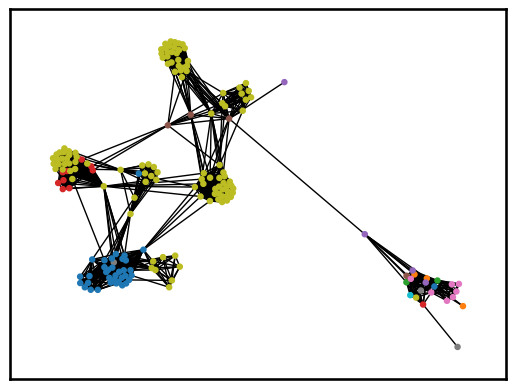

In [28]:
# ----- examine data from above ----- #
# - sort by n_nodes; look at biggest ones first
G_cc_data_sort_n_nodes = G_cc_data.sort_values(by=['n_nodes'], ascending=False).reset_index()

# G_cc_data_sort_n_nodes.head()

# --- examine largest cc --- #
largest_cc_nodes = G_cc_data_sort_n_nodes.loc[0, 'nodes'] # loc is label; iloc is just regular 'k'th row.
largest_cc_id = G_cc_data_sort_n_nodes.loc[0, 'cc_id']

# - Method 1: create_subgraph
largest_cc_subgraph, largest_cc_subdataframe = create_subgraph(graph = G, dataframe = filtered_data, node_subset = list(largest_cc_nodes))
# print(largest_cc_subdataframe.shape)
colors_list = largest_cc_subdataframe["color"] # extract list of colors for nodes
nx.draw_networkx(largest_cc_subgraph, node_size=10, width=1, with_labels=False, node_color = colors_list)



In [29]:
# ----- extract important sequences from this cc ----- #
largest_cc_node_data = cc_id_df_dict[largest_cc_id]

print(largest_cc_node_data.columns)

# ---- dict of {node : sequence} for faster access --- #
node_sequence_dict = nx.get_node_attributes(largest_cc_subgraph, "junction_aa")

# --- sort by column --- #
sort_column = "n_different_subject_neighbors"

largest_cc_node_data_sorted = largest_cc_node_data.sort_values(by=[sort_column], ascending=False).reset_index(drop=True) # reset to use loc
# print(largest_cc_node_data_sorted.head())


# --- print sequences --- #
# Method 1: print fixed number of sequences
print_n = 5

candidate_sequences = []
for row in range(print_n):
    candidate_node = largest_cc_node_data_sorted.loc[row, "node"]
    candidate_sequences.append(node_sequence_dict[candidate_node])
    
print(f"{print_n} sequences with highest " + sort_column + ":")
print(candidate_sequences)

# Method 2: based on condition/threshold
stat_threshold = 10
want_greater = True

candidate_sequences = []
for row in range(largest_cc_node_data_sorted.shape[0]):

    candidate_node = largest_cc_node_data_sorted.loc[row, "node"]
    candidate_node_stat = largest_cc_node_data_sorted.loc[row, sort_column]

    if want_greater:
        if candidate_node_stat >= stat_threshold:
            candidate_sequences.append(node_sequence_dict[candidate_node])
        else:
            # since it's sorted, we can stop here.
            break
    else:
        if candidate_node_stat <= stat_threshold:
            candidate_sequences.append(node_sequence_dict[candidate_node])
        else:
            break

if want_greater:
    print(f"Sequences with " + sort_column + f" >= {stat_threshold}:")
else:
    print(f"Sequences with " + sort_column + f" <= {stat_threshold}:")
    
print(candidate_sequences)


Index(['node', 'degree_frac', 'degree', 'betweenness_centrality',
       'n_unique_subjects_among_neighbors', 'n_different_subject_neighbors'],
      dtype='object')
5 sequences with highest n_different_subject_neighbors:
['CAAPSCSRTTCYDGFNLW', 'CAAPPCSRTTCYDGFNLW', 'CAAPSCSRTTCYDGFILW', 'CAAPSCSGGTCFDAFDIW', 'CAAPYCSSTSCYDAFDIW']
Sequences with n_different_subject_neighbors >= 10:
['CAAPSCSRTTCYDGFNLW', 'CAAPPCSRTTCYDGFNLW', 'CAAPSCSRTTCYDGFILW', 'CAAPSCSGGTCFDAFDIW', 'CAAPYCSSTSCYDAFDIW', 'CAAPYCSSTSCYDAFDIW', 'CAAVYCSSTSCSDAFDIW', 'CAAPNCSRTTCYDGFDLW', 'CAAVYCSSTSCFDAFDIW', 'CAAPYCSSTSCDDAFDIW', 'CAAPYCSSTSCSDAFDIW', 'CAAPYCSSTSCHDAFDIW', 'CAAVTCSSTSCYDAFDIW', 'CAAPYCSSTSCHDAFDIW', 'CAAPYCSSTSCSDAFDIW', 'CAAPSCSGGTCFDGFDLW', 'CAAPNCSSTSCYSAFDIW', 'CASPDCSSTSCYDAFDIW', 'CAAPSCSGGTCFDGFNLW', 'CAAPYCSRTTCYDGFDLW', 'CAAPHCSTTSCYDAFDIW']


### KNN and LISI Metric Experimentation

In [30]:
# ----- compute KNN matrix ----- #
k = 10 # number of nearest neighbors to grab

# - no edge weights - #
# largest_cc_subgraph_distances = dict(nx.all_pairs_shortest_path_length(largest_cc_subgraph)) # edges = 1

# - with edge weights - #
largest_cc_subgraph_distances = dict(nx.all_pairs_dijkstra_path_length(largest_cc_subgraph, weight='hamming_distance')) 

largest_cc_subgraph_knn_matrix = pd.DataFrame()

for node in largest_cc_subgraph.nodes:
    distances_dict = largest_cc_subgraph_distances[node]
    sorted_distances_tuple_list = sorted(distances_dict.items(), key=lambda x:x[1]) # sort by distances; includes itself

    closest_k_neighbors = [neighbor for (neighbor, distance) in sorted_distances_tuple_list[1:(k+1)]] # don't include item 0 (itself)

    row_df = pd.DataFrame([closest_k_neighbors]) # to be concatenated
    row_df.columns = [f"neighbor_{i:d}" for i in range(k)]
    row_df.index = [node]

    largest_cc_subgraph_knn_matrix = pd.concat([largest_cc_subgraph_knn_matrix, row_df])


print(largest_cc_subgraph_knn_matrix)


      neighbor_0  neighbor_1  neighbor_2  neighbor_3  neighbor_4  neighbor_5  \
1025         472         490        1595         475         476         477   
1538         430         765         782        1096        1539         275   
1539        1538         430         765         782        1398         275   
1039         275         430         765        1538        1539         431   
1050        1051        1052        1053        1054        1055        1056   
...          ...         ...         ...         ...         ...         ...   
494          472         478         488        1025         475         476   
495          492         472         477         478         494         497   
496          472        1025         475         476         477         478   
497          475         492         472         477         488         489   
498          472        1025         475         476         477         478   

      neighbor_6  neighbor_7  neighbor_

In [31]:
# ----- UNFINISHED: create adata object ----- #
# adata.X - main data matrix
# adata.obs - indexes (ie. row names) of X
# adata.vars - variables (ie. column names) of X
# adata.uns - unstructured annotations
#     adata.uns["neighbors"] = k nearest neighbors
# adata.obsp - can handle more data?
#     adata.obsp["connectivities"] = adjacency matrix?

# index --> obs_names, colnames --> var_names
# !obs_names/index is converted to string
test = ad.AnnData(largest_cc_subgraph_knn_matrix) 

node_subject_id_dict = nx.get_node_attributes(largest_cc_subgraph, "subject_id")

index_list = [eval(i) for i in list(test.obs.index)] # list of nodes in the index (eval(str) --> int)
# print(index_list)

# code uses np.unique which sorts things; can't compare int and string.
test.obs["subject_id"] = list(map(node_subject_id_dict.get, index_list))
test.obs["subject_id"] = test.obs.subject_id.astype("string").astype('category') # no numerical categories; all strings
# print(test.obs["subject_id"])

test.uns["neighbors"] = largest_cc_subgraph_knn_matrix

temp = nx.adjacency_matrix(largest_cc_subgraph) # !uses indices 0, 1, ..., 181 instead of node index (name); describes adj matrix ig
# print(temp) # csr array; collection of edge pairs (i,j)
test.obsp["connectivities"] = temp

print(test.obs["subject_id"].cat.codes.values)
# print(test.obsp["connectivities"])

# print(largest_cc_subgraph.nodes())
# print(temp)

# ----- call LISI function ----- #
# requires: adata.uns["neighbors"] stores knn graph
#           adata.obs[obs_key] stores labels

scib.me.clisi_graph(test, label_key="subject_id", type_="knn", k0=10, verbose=True)
# scib.me.lisi_graph_py(test, label_key="subject_id", type_="knn", k0=10, verbose=True) # function not found
# scib.metrics.compute_simpson_index(test) # function not found



[ 8  3  3  6 17 17 17 17 17 17 17 17 17  8  8  8  8  8  8  8  8  8  0  0
  0  9  9  9 10 10 10 10 10 10 15 16 16 16 16 16 16 16 16 16 16 16 16 16
 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16
 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 13 16 16 16 16 16 16 16 16
 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16
 16 16 16 16 16 16 16 16  2 12 16 16 16 16 16 16 16 16 16 16 16 16 16 16
 16 16 16 16 16  1  7 14  5 11 11  8 16  4  8  8  8  8  8  8  8  8  8  8
  8  8  8  8  8  8  8  8  8  8  8  8  8  8]
using precomputed kNN graph
Convert nearest neighbor matrix and distances for LISI.
Compute knn on shortest paths
call /opt/anaconda3/envs/sds491/lib/python3.10/site-packages/scib/knn_graph/knn_graph.o /var/folders/tn/8v9b2jz532d4p2kt9n5qn_jc0000gn/T/lisi_xmpl53bv/graph_lisi_input.mtx /var/folders/tn/8v9b2jz532d4p2kt9n5qn_jc0000gn/T/lisi_xmpl53bv/graph_lisi 10 1 100


/opt/anaconda3/envs/sds491/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


OSError: [Errno 8] Exec format error: '/opt/anaconda3/envs/sds491/lib/python3.10/site-packages/scib/knn_graph/knn_graph.o'

In [34]:
module_path = os.path.abspath(os.path.join('../Senior Thesis/')) # or the path to your source code
# print(module_path)
if module_path not in sys.path:
    sys.path.append(module_path)
# print(sys.path)

import manual_lisi # have to restart kernel each time? 

# :param D: knn distance matrix, (n_nodes, k_nearest_neighbors)
# :param knn_idx: indexes of the k_nearest neighbors to each node, (n_nodes, k_nearest_neighbors)
# :param batch_labels: vector of labels/subject_ids (n_nodes)
# compute_simpson_index(D=None, knn_idx=None, batch_labels=None, n_batches=None, perplexity=15, tol=1e-5)



In [35]:
import itertools
import logging
import multiprocessing as mp
import os
import pathlib
import subprocess
import tempfile
import warnings

import numpy as np
import pandas as pd
import scanpy as sc
import scipy.sparse
from deprecated import deprecated
from scipy.io import mmwrite

In [36]:
def lisi_graph_py(
    adata,
    obs_key,
    n_neighbors=90,
    perplexity=None,
    subsample=None,
    n_cores=1,
    verbose=False,
):
    """
    Function to prepare call of compute_simpson_index
    Compute LISI score on shortes path based on kNN graph provided in the adata object.
    By default, perplexity is chosen as 1/3 * number of nearest neighbours in the knn-graph.
    """
    # use no more than the available cores
    n_cores = max(1, min(n_cores, mp.cpu_count()))

    if "neighbors" not in adata.uns:
        raise AttributeError(
            "Key 'neighbors' not found. Please make sure that a kNN graph has been computed"
        )
    elif verbose:
        print("using precomputed kNN graph")

    # get knn index matrix
    if verbose:
        print("Convert nearest neighbor matrix and distances for LISI.")

    batch = adata.obs[obs_key].cat.codes.values
    n_batches = len(np.unique(adata.obs[obs_key]))

    if perplexity is None or perplexity >= n_neighbors:
        # use LISI default
        perplexity = np.floor(n_neighbors / 3)

    # setup subsampling
    subset = 100  # default, no subsampling
    if subsample is not None:
        subset = subsample  # do not use subsampling
        if isinstance(subsample, int) is False:  # need to set as integer
            subset = int(subsample)

    # run LISI in python
    if verbose:
        print("Compute knn on shortest paths")

    # set connectivities to 3e-308 if they are lower than 3e-308 (because cpp can't handle double values smaller than that).
    connectivities = adata.obsp["connectivities"]  # csr matrix format
    large_enough = connectivities.data >= 3e-308
    if verbose:
        n_too_small = np.sum(large_enough is False)
        if n_too_small:
            print(
                f"{n_too_small} connectivities are smaller than 3e-308 and will be set to 3e-308"
            )
            print(connectivities.data[large_enough is False])
    connectivities.data[large_enough is False] = 3e-308

    # temporary file
    tmpdir = tempfile.TemporaryDirectory(prefix="lisi_")
    prefix = tmpdir.name + "/graph_lisi"
    mtx_file_path = prefix + "_input.mtx"

    mmwrite(mtx_file_path, connectivities, symmetry="general")
    # call knn-graph computation in Cpp

    root = pathlib.Path(scib.__file__).parent  # get current root directory
    cpp_file_path = (
        root / "knn_graph/knn_graph.o"
    )  # create POSIX path to file to execute compiled cpp-code
    # comment: POSIX path needs to be converted to string - done below with 'as_posix()'
    # create evenly split chunks if n_obs is divisible by n_chunks (doesn't really make sense on 2nd thought)
    args_int = [
        cpp_file_path.as_posix(),
        mtx_file_path,
        prefix,
        str(n_neighbors),
        str(n_cores),  # number of splits
        str(subset),
    ]
    if verbose:
        print(f'call {" ".join(args_int)}')
    try:
        subprocess.run(args_int)
    except RuntimeError as ex:
        print(f"Error computing LISI kNN graph {ex}\nSetting value to np.nan")
        return np.nan

    if verbose:
        print("LISI score estimation")

    if n_cores > 1:
        if verbose:
            print(f"{n_cores} processes started.")
        pool = mp.Pool(processes=n_cores)
        chunk_no = np.arange(0, n_cores)

        # create argument list for each worker
        results = pool.starmap(
            compute_simpson_index_graph,
            zip(
                itertools.repeat(prefix),
                itertools.repeat(batch),
                itertools.repeat(n_batches),
                itertools.repeat(n_neighbors),
                itertools.repeat(perplexity),
                chunk_no,
            ),
        )
        pool.close()
        pool.join()

        simpson_estimate_batch = np.concatenate(results)

    else:
        simpson_estimate_batch = compute_simpson_index_graph(
            file_prefix=prefix,
            batch_labels=batch,
            n_batches=n_batches,
            perplexity=perplexity,
            n_neighbors=n_neighbors,
        )

    tmpdir.cleanup()

    return 1 / simpson_estimate_batch

In [37]:
lisi_graph_py(
    test,
    obs_key="subject_id",
    n_neighbors=10,
    perplexity=None,
    subsample=None,
    n_cores=1,
    verbose=True,
)

using precomputed kNN graph
Convert nearest neighbor matrix and distances for LISI.
Compute knn on shortest paths
call /opt/anaconda3/envs/sds491/lib/python3.10/site-packages/scib/knn_graph/knn_graph.o /var/folders/tn/8v9b2jz532d4p2kt9n5qn_jc0000gn/T/lisi_09q63av3/graph_lisi_input.mtx /var/folders/tn/8v9b2jz532d4p2kt9n5qn_jc0000gn/T/lisi_09q63av3/graph_lisi 10 1 100


OSError: [Errno 8] Exec format error: '/opt/anaconda3/envs/sds491/lib/python3.10/site-packages/scib/knn_graph/knn_graph.o'